# RSTDP domain adaptation of pre-trained agents for modified CartPole environments

In [1]:
import os, sys
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy

import torch.nn.functional as F

# script_dir = os.path.dirname( __file__ )
# mymodule_dir = os.path.join( script_dir, '..', 'alpha', 'beta' )
# sys.path.append( script_dir )


from utils import evaluate_policy, rstdp_train_cartpole

import site
site.addsitedir('../src/')

from dsnn import RSTDPNet
from model import DSNN

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

cuda:0


In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 200
max_steps = 200

n_evaluations = 100
rstdp_episodes = 250

In [4]:
# Create environments
original_env = gym.make(env_name)

modified_env = gym.make(env_name)
modified_env.unwrapped.length *= 0.5

/home3/p306982/.conda/envs/drl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
# SNN Hyperparameters
simulation_time = 8
alpha = 0.8
beta = 0.8
threshold = 0.5
weight_scale = 1
architecture = [8, 64, 64, 2]

In [6]:
# RSTDP Hyperparameters
tau = 5
tau_e = 10
C = 0.01
# A+/- are calculated from the pre-trained network weights

In [7]:
evaluation_seeds = np.load('../seeds/evaluation_seeds.npy')
rstdp_seeds = np.load('../seeds/rstdp_training_seeds.npy')

In [8]:
# Load pre-trained model weights
weights_0 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_0.pt', map_location=torch.device(device))
weights_1 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_1.pt', map_location=torch.device(device))
weights_2 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_2.pt', map_location=torch.device(device))
weights = [weights_0, weights_1, weights_2]

In [9]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained models on original environment

In [10]:
original_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
    original_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  199.73
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00


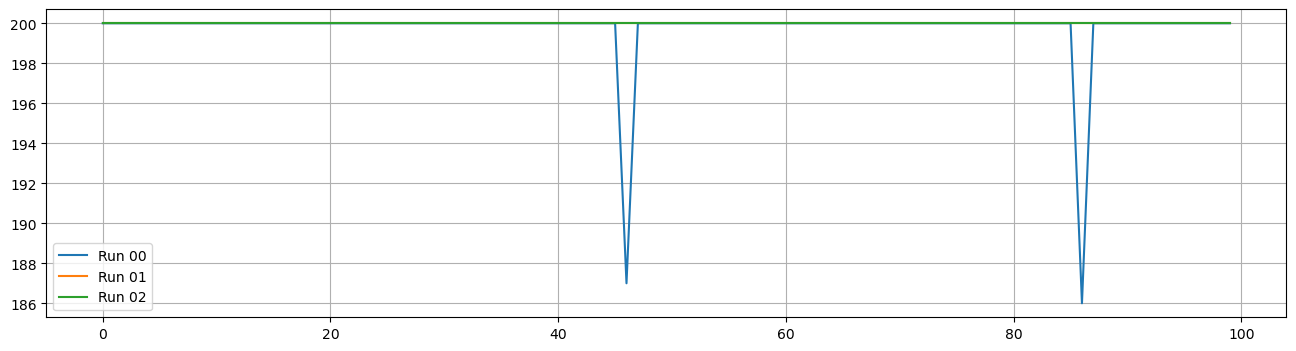

In [11]:
plt.figure(figsize=(16, 4))

for i, oer in enumerate(original_eval_rewards):
    plt.plot(oer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### Evaluate pre-trained models on modified environment

In [11]:
modified_env_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    modified_env_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  186.41
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  132.76


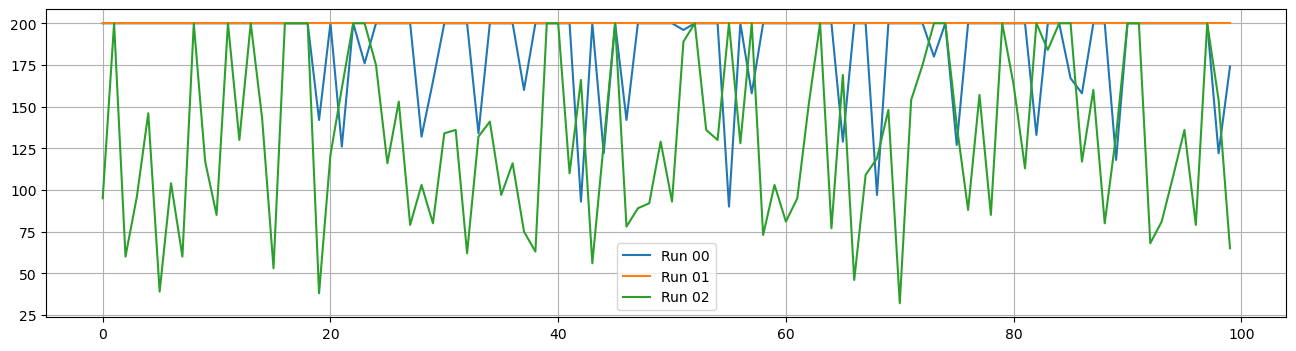

In [12]:
plt.figure(figsize=(16, 4))

for i, meer in enumerate(modified_env_eval_rewards):
    plt.plot(meer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### RSTDP Adaptation

In [13]:
rstdp_adaptation_rewards = []
adapted_weights_collection = []

for i, w in enumerate(weights):
    w_plus = deepcopy(w[0][1])
    w_minus = deepcopy(w[0][1])
    w_plus[w_plus < 0] = 0
    w_minus[w_minus > 0] = 0
    A_plus = torch.mean(w_plus)
    A_minus = torch.abs(torch.mean(w_minus))
    
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  tau, tau_e, A_plus, A_minus, C, 
                                  device=device, dtype=dtype)
    
    adapted_weights, rewards = rstdp_train_cartpole(policy_net, modified_env, max_reward, rstdp_episodes, 
                                                 n_evaluations, max_steps, rstdp_seeds, evaluation_seeds)
    
    rstdp_adaptation_rewards.append(rewards)
    adapted_weights_collection.append(adapted_weights)
    
adapted_weights_collection = [(list(aw.values()), []) for aw in adapted_weights_collection]

### Temporal Difference Delta Rule Adaptation

In [31]:
modified_env = gym.make(env_name)
modified_env.unwrapped.length *= 3

In [32]:
# Hyperparameters
n_evaluations = 1
batch_size = 1
discount_factor = 0.999
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.999
update_every = 4
target_update_frequency = 100
learning_rate = 0.001
replay_memory_size = 4*10**4
tau = 1e-3

In [26]:
print(weights[0][0][0].shape)
print(weights[0][0][1].shape)
print(weights[0][0][2].shape)

torch.Size([8, 64])
torch.Size([64, 64])
torch.Size([64, 2])


In [33]:
from dsnn import TDDeltaNet

lr = learning_rate
num_episodes = rstdp_episodes

weight_seed = weights[0]
full_net = TDDeltaNet(alpha, beta, threshold, architecture, simulation_time, weight_seed,
                                  device=device, dtype=dtype)
action_net = full_net.l3
actor_weights = action_net.weights

In [124]:
from dsnn import transform_state

DEBUG=False
td_learning_rate = 0.0001
num_episodes = 50
if DEBUG:
    num_episodes = 1
gamma = 0.9
trace_decay = 0.9

modified_env._max_episode_steps = max_steps

rewards = []
time_rewards = []
td_errors = []
hidden_traces = []
action_traces = []
hidden_spikes = []
values = []

for i_episode in range(num_episodes):
    modified_env.seed(int(rstdp_seeds[i_episode]))
    
    state = modified_env.reset()
    total_reward = 0
    hidden_trace = torch.zeros((batch_size, architecture[-2]), device=device)
    action_trace = torch.zeros((batch_size, architecture[-1]), device=device)
    value = 0
    value_update = torch.zeros((architecture[-2], 1), device=device)
    action_update = torch.zeros((architecture[-2], architecture[-1]), device=device)
    for t in range(max_steps):
        inputs = torch.from_numpy(state).float().to(device)

        ### INFERENCE ###

        out_mem = full_net.forward(inputs)
        action = torch.argmax(out_mem)
        state, time_reward, done, _ = modified_env.step(action.cpu().numpy())
        reward = -abs(state[2]/0.2)

        ### GET Weight UPDATE ###

        z_spk = full_net.get_hidden(inputs)
        # if DEBUG:
        #     print(torch.sum(z_spkcount))

        # Loop over simulation time during 1 fixed state of the cartpole
        for t in range(z_spk.shape[1]):

            z_t = z_spk[:, t, ...]
            # TD Delta Update
            hidden_trace = trace_decay*hidden_trace + z_t

        new_value = full_net.value(z_spk)[1][0]

        action_oh = F.one_hot(action, num_classes=actor_weights.size()[-1])
        action_trace = trace_decay*action_trace + action_oh


        td_error = reward + gamma*new_value - value

        value_learning_value = torch.einsum("bz,bv->zv", [hidden_trace, td_error])
        full_net.value.weights += td_learning_rate*value_learning_value
        action_learning_value = torch.einsum("bz,ba->bza", [hidden_trace, action_trace])
        full_net.l3.weights += td_learning_rate*torch.einsum("bza,bv->za", [action_learning_value, td_error])

        value = new_value
        
        rewards.append(reward)
        td_errors.append(torch.squeeze(td_error).cpu().numpy())
        hidden_traces.append(hidden_trace[0, 0].cpu().numpy())
        action_traces.append(action_trace[0, 0].cpu().numpy())
        hidden_spikes.append(torch.sum(z_spk[:, :,0], dim=1).cpu().numpy())
        values.append(torch.squeeze(value).cpu().numpy())

        total_reward += time_reward
        if done: ### DONE WHEN FULLY FALLING: LEAVE SOME WRONG ANGLE TO TRAIN ON
            break

    if DEBUG:
        print(total_reward)
        fig, axs = plt.subplots(6) 
        axs[0].plot(rewards)
        axs[1].plot(td_errors)
        axs[2].plot(hidden_spikes)
        axs[3].plot(hidden_traces)
        axs[4].plot(action_traces)
        axs[5].plot(values)

    # print(value_weights[0])
    print('REWARD', total_reward)
    time_rewards.append(total_reward)
print(np.average(time_rewards))
plt.plot(time_rewards)
    # eval_rewards = evaluate_policy(policy_net, env, n_evaluations, evaluation_seeds)
    # avg_eval_reward = np.mean(eval_rewards)

REWARD 49.0
REWARD 49.0
REWARD 49.0
REWARD 46.0
REWARD 48.0
REWARD 51.0
REWARD 52.0
REWARD 51.0
REWARD 54.0
REWARD 51.0
REWARD 54.0
REWARD 49.0
REWARD 54.0
REWARD 49.0
REWARD 53.0
REWARD 54.0
REWARD 58.0
REWARD 52.0
REWARD 56.0
REWARD 49.0
REWARD 55.0
REWARD 55.0
REWARD 51.0
REWARD 54.0
REWARD 58.0
REWARD 106.0
REWARD 99.0
REWARD 56.0
REWARD 51.0
REWARD 53.0
REWARD 59.0
REWARD 56.0
REWARD 55.0
REWARD 59.0
REWARD 59.0
REWARD 55.0
REWARD 55.0
REWARD 52.0
REWARD 49.0
REWARD 51.0
REWARD 47.0
REWARD 54.0


KeyboardInterrupt: 

In [45]:
from dsnn import transform_state


def test(learning_rate=0.0001, num_episodes=50, DEBUG=False):


    weight_seed = weights[0]
    full_net = TDDeltaNet(alpha, beta, threshold, architecture, simulation_time, weight_seed,
                                    device=device, dtype=dtype)
    action_net = full_net.l3
    actor_weights = action_net.weights

    DEBUG=DEBUG
    td_learning_rate = learning_rate
    num_episodes = num_episodes
    if DEBUG:
        num_episodes = 1
    gamma = 0.9
    trace_decay = 0.5

    modified_env._max_episode_steps = max_steps

    rewards = []
    time_rewards = []
    td_errors = []
    hidden_traces = []
    action_traces = []
    hidden_spikes = []
    values = []

    for i_episode in range(num_episodes):
        modified_env.seed(int(rstdp_seeds[i_episode]))
        
        state = modified_env.reset()
        total_reward = 0
        hidden_trace = torch.zeros((batch_size, architecture[-2]), device=device)
        action_trace = torch.zeros((batch_size, architecture[-1]), device=device)
        value = 0
        value_update = torch.zeros((architecture[-2], 1), device=device)
        action_update = torch.zeros((architecture[-2], architecture[-1]), device=device)
        for t in range(max_steps):
            if DEBUG:
                print('t', t)
            inputs = torch.from_numpy(state).float().to(device)

            ### INFERENCE ###

            out_mem = full_net.forward(inputs)
            action = torch.argmax(out_mem)
            state, time_reward, done, _ = modified_env.step(action.cpu().numpy())
            reward = -abs(state[2]/0.2)

            ### GET Weight UPDATE ###

            z_spk = full_net.get_hidden(inputs)
            # if DEBUG:
            #     print(torch.sum(z_spkcount))

            # Loop over simulation time during 1 fixed state of the cartpole
            for t in range(z_spk.shape[1]):

                z_t = z_spk[:, t, ...]
                # TD Delta Update
                hidden_trace = trace_decay*hidden_trace + z_t

            new_value = full_net.value(z_spk)[1][0]

            action_oh = F.one_hot(action, num_classes=actor_weights.size()[-1])
            action_trace = trace_decay*action_trace + action_oh


            td_error = reward + gamma*new_value - value

            value_learning_value = torch.einsum("bz,bv->zv", [hidden_trace, td_error])
            full_net.value.weights += td_learning_rate*value_learning_value
            action_learning_value = torch.einsum("bz,ba->bza", [hidden_trace, action_trace])
            full_net.l3.weights += td_learning_rate*torch.einsum("bza,bv->za", [action_learning_value, td_error])

            value = new_value
            if DEBUG:
                print('DONE', done)
                print('hidden_trace', torch.sum(hidden_trace))
                print('action_trace', torch.sum(action_trace))
                print('REWARD', reward)
                print('VALUE', value)
                print(torch.squeeze(value).cpu().numpy())
                print('TD error', td_error)
                print('Value update', value_learning_value[0])
                print('Action update', action_learning_value)
            
            rewards.append(reward)
            td_errors.append(torch.squeeze(td_error).cpu().numpy())
            hidden_traces.append(hidden_trace[0, 0].cpu().numpy())
            action_traces.append(action_trace[0, 0].cpu().numpy())
            hidden_spikes.append(torch.sum(z_spk[:, :,0], dim=1).cpu().numpy())
            values.append(torch.squeeze(value).cpu().numpy())

            total_reward += time_reward
            if done: ### DONE WHEN FULLY FALLING: LEAVE SOME WRONG ANGLE TO TRAIN ON
                break

        if DEBUG:
            print(values)
            fig, axs = plt.subplots(6) 
            axs[0].plot(rewards[:100])
            axs[1].plot(td_errors[:100])
            axs[1].set_yscale('log')
            axs[2].plot(hidden_spikes[:100])
            axs[3].plot(hidden_traces[:100])
            axs[4].plot(action_traces[:100])
            axs[5].plot(values[:100])
            axs[5].set_yscale('log')

        # print(value_weights[0])
        # print('REWARD', total_reward)
        time_rewards.append(total_reward)
    print(np.average(time_rewards))
    plt.plot(time_rewards)
        # eval_rewards = evaluate_policy(policy_net, env, n_evaluations, evaluation_seeds)
        # avg_eval_reward = np.mean(eval_rewards)

61.32


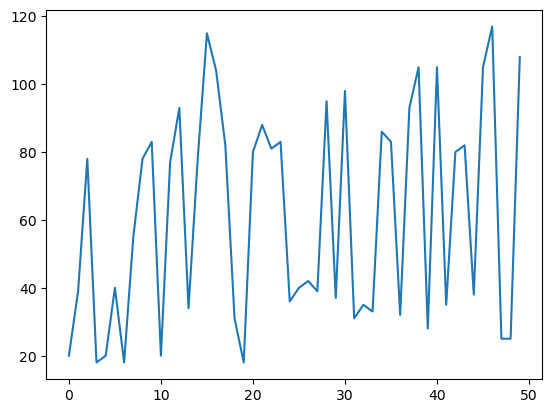

In [47]:
test(0)

62.42


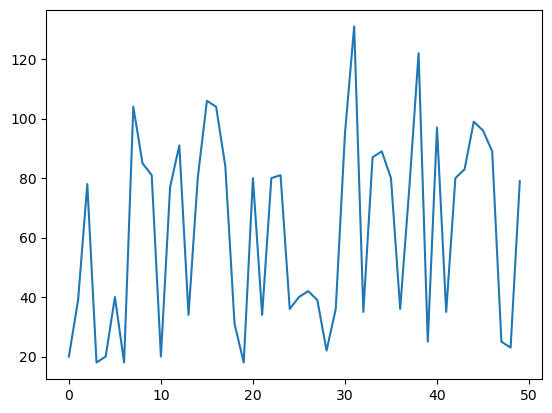

In [46]:
test(0.00002)

40.5


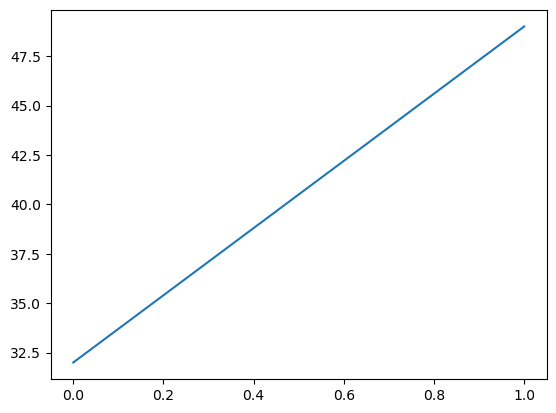

In [122]:
test(0,2)

t 0
DONE False
hidden_trace tensor(74.7031, device='cuda:0')
action_trace tensor(1., device='cuda:0')
REWARD -0.22848079807033703
VALUE tensor([[0.]], device='cuda:0')
0.0
TD error tensor([[-0.2285]], device='cuda:0')
Value update tensor([-0.], device='cuda:0')
Action update tensor([[[0.0000, 0.0000],
         [0.0000, 1.9375],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 1.9844],
         [0.0000, 1.9844],
         [0.0000, 0.0234],
         [0.0000, 1.9844],
         [0.0000, 1.7500],
         [0.0000, 1.9922],
         [0.0000, 0.4922],
         [0.0000, 1.7500],
         [0.0000, 1.9922],
         [0.0000, 1.9688],
         [0.0000, 1.9844],
         [0.0000, 0.1172],
         [0.0000, 1.9922],
         [0.0000, 1.9922],
         [0.0000, 0.0234],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 1.9922],
         [0.0000, 0.0000],
         [0.0000, 0.0625],
         [0.0000, 0.0000],
         [0.0000, 1.99

/tmp/ipykernel_1017132/2116711011.py:112: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[5].set_yscale('log')


94.0


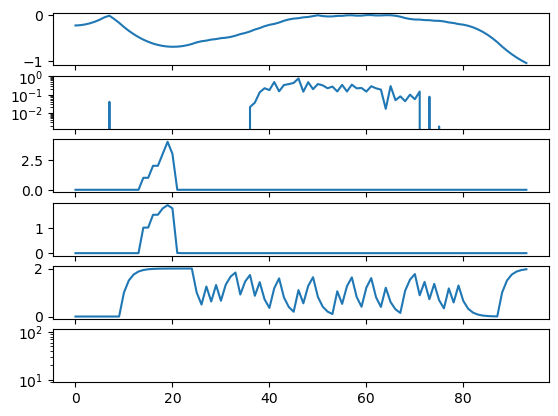

In [48]:
test(0.0005, 1, True)

57.5


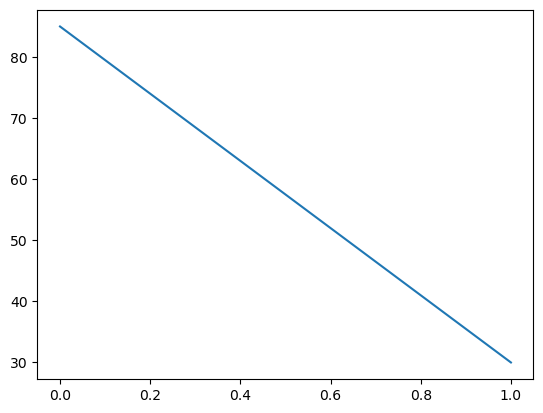

In [123]:
test(0.001, 2)

In [105]:
print(full_net.value.weights)

Parameter containing:
tensor([[-5.8028e-02],
        [ 1.3876e-02],
        [-4.6794e-02],
        [-2.1160e-02],
        [-6.5274e-03],
        [-1.1158e-02],
        [ 1.4258e-02],
        [ 2.4070e-02],
        [-8.7123e-03],
        [-2.3021e-02],
        [ 5.5939e-05],
        [-2.3316e-02],
        [-1.6715e-03],
        [ 7.4907e-03],
        [-2.9022e-02],
        [-3.2648e-02],
        [-2.5544e-02],
        [-1.0584e-02],
        [-2.3084e-02],
        [-2.3914e-02],
        [ 1.7426e-02],
        [-4.5012e-02],
        [-1.1314e-02],
        [-3.1790e-02],
        [ 2.3100e-03],
        [-1.1077e-02],
        [-2.4732e-02],
        [-7.1452e-03],
        [ 7.1035e-04],
        [ 1.1985e-03],
        [-1.4523e-02],
        [ 1.2611e-02],
        [-2.2059e-03],
        [-2.2610e-02],
        [-1.2019e-04],
        [-9.5961e-03],
        [ 1.2459e-02],
        [ 2.0186e-03],
        [-1.2745e-02],
        [-2.5560e-03],
        [ 3.1817e-02],
        [-1.2964e-02],
        [-1.

In [59]:
%load_ext autoreload
%autoreload 2
from model import DSNN

lr = learning_rate
num_episodes = rstdp_episodes
env = modified_env

hidden_net = DSNN(architecture[:-1], 0, alpha, beta, weight_scale, batch_size, threshold,
                      simulation_time, learning_rate, spk_out_sum=True)
weight_seed0 = weights[0]
hidden_net.load_weights(weight_seed0[0][:-1]) #Only hidden network
actor_weights = weight_seed0[0][-1]
value_weights = torch.empty((architecture[-2], architecture[-1]), device=device, dtype=torch.float, requires_grad=False)
torch.nn.init.normal_(value_weights, mean=0.0, std=weight_scale/np.sqrt(architecture[-1]))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensor([[ 1.7989, -0.5065],
        [-0.3489,  0.0896],
        [ 0.0717, -0.2853],
        [ 0.6380,  0.5727],
        [-0.4868,  0.0970],
        [ 0.7338,  0.0654],
        [-0.2653, -0.0642],
        [ 1.4594, -1.2844],
        [-0.1922,  0.1988],
        [-0.7353,  0.5491],
        [ 0.6233,  0.0314],
        [-1.0515,  0.8015],
        [ 0.9382, -0.8921],
        [ 0.6718, -0.4637],
        [ 0.6433, -0.4448],
        [-0.4658,  1.4716],
        [ 1.0006, -0.2186],
        [-0.1453,  1.4540],
        [-0.0347, -0.4498],
        [-0.3790, -0.0926],
        [-0.2083,  0.8680],
        [ 0.7459,  0.2528],
        [ 1.1581, -0.1634],
        [ 0.5574, -0.0571],
        [-0.2775,  0.8962],
        [ 0.7368, -0.3497],
        [-0.8229,  1.1130],
        [ 0.5032,  0.4316],
        [ 0.9088, -0.4619],
        [ 0.7899, -0.7118],
        [ 0.9130,  1.1334],
        [ 0.0942,  0.7568],
        [-0.7892, -0.5937],
        [-2.5937,  0.5790],
        [ 0.0887, -0.5439],
        [ 0.1097, -0

In [36]:
for t in range(max_steps):
    state = env.reset()
    print(state)

[-0.04164862  0.01279319 -0.03198613 -0.04354728]
[-0.0338814  -0.02272913 -0.04876121 -0.00927737]
[ 0.00907432 -0.04978249  0.01365784  0.00348372]
[-0.00241364  0.02709097  0.0491919  -0.03837302]
[ 0.02797048 -0.0213679  -0.03647558 -0.0377784 ]
[ 0.01954947 -0.0149603  -0.01214877 -0.02309371]
[-0.02227033  0.01900424  0.0299077   0.01418891]
[ 0.02994294 -0.03585773  0.03368881 -0.0368263 ]
[ 0.04452436  0.02773551  0.04460242 -0.01610783]
[-0.04779275 -0.04554034 -0.01462114  0.0363768 ]
[ 0.03813785  0.02835837 -0.04054477  0.04001045]
[-0.0106544  -0.03896252 -0.00124269  0.02718378]
[-0.02351293 -0.04978914 -0.01218092 -0.04346545]
[-0.03642882  0.00428937 -0.0188272  -0.04750161]
[-0.00549906 -0.0019812  -0.03596947  0.03843012]
[-0.0028367   0.00878644 -0.01685082 -0.04626367]
[-0.01287867 -0.02737688  0.04976248  0.03821711]
[ 0.04473881  0.04417277 -0.04542288  0.00224569]
[-0.00281019  0.04253444  0.02623526  0.01103189]
[-0.0362462  -0.03594795 -0.02588833 -0.01308069]


In [55]:
print(max_steps)
range(max_steps)

200


range(0, 200)

In [60]:
from dsnn import transform_state

DEBUG=True
if DEBUG:
    num_episodes = 2
gamma = 0.9
trace_decay = 0.7
td_learning_rate = 0

env._max_episode_steps = max_steps

best_reward = -np.inf
best_episode = -1
best_weights = None

rewards = []

for i_episode in range(num_episodes):
    env.seed(int(rstdp_seeds[i_episode]))
    
    e_trace = None
    
    state = env.reset()
    total_reward = 0
    hidden_trace = torch.zeros((batch_size, architecture[-2]), device=device)
    action_trace = torch.zeros((batch_size, architecture[-1]), device=device)
    value = 0
    for t in range(max_steps):
        if DEBUG:
            print('t', t)
        inputs = torch.from_numpy(state).float()
        inputs = transform_state(inputs)
        inputs = inputs.unsqueeze(dim=0).to(device)

        z_spkcount = hidden_net.forward(inputs)
        # if DEBUG:
        #     print(torch.sum(z_spkcount))
        hidden_act = z_spkcount/simulation_time

        new_value = torch.einsum("bz,zv->bv", [hidden_act, value_weights])
        action_logits = torch.einsum("bz,za->ba", [hidden_act, actor_weights])

        # Action definition + application
        action = torch.argmax(action_logits)
        action_oh = F.one_hot(action, num_classes=actor_weights.size()[-1])

        state, time_reward, done, _ = env.step(action.cpu().numpy())
        reward = -abs(state[2]/0.2)

        # TD Delta Update
        hidden_trace = trace_decay*hidden_trace + hidden_act
        action_trace = trace_decay*action_trace + action_oh



        td_error = reward + gamma*new_value - value

        value_learning_value = torch.einsum("bz,bv->zv", [hidden_trace, td_error])
        value_weights += td_learning_rate*value_learning_value
        action_learning_value = torch.einsum("bz,ba->bza", [hidden_trace, action_trace])
        actor_weights += td_learning_rate*torch.einsum("bza,bv->za", [action_learning_value, td_error])


        if DEBUG:
            print('DONE', done)
            print('hidden_trace', torch.sum(hidden_trace))
            print('action_trace', torch.sum(action_trace))
            print('REWARD', reward)
            print('VALUE', value)
            print('TD error', td_error)
            print('Value update', value_learning_value[0])
            print('Action update', action_learning_value)
        value = new_value

        total_reward += time_reward
        # if done: ### DONE WHEN FULLY FALLING: LEAVE SOME WRONG ANGLE TO TRAIN ON
        #     break

    # print(value_weights[0])
    print('REWARD', total_reward)
    rewards.append(total_reward)
    
    # eval_rewards = evaluate_policy(policy_net, env, n_evaluations, evaluation_seeds)
    # avg_eval_reward = np.mean(eval_rewards)

t 0
DONE False
hidden_trace tensor(2.7500, device='cuda:0')
action_trace tensor(1., device='cuda:0')
REWARD -0.22848079807033703
VALUE 0
TD error tensor([[ 0.2510, -2.9243]], device='cuda:0')
Value update tensor([0., -0.], device='cuda:0')
Action update tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.5000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000,

In [41]:
value_weights

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],


### Evaluate adapted models on modified environment

In [ ]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

In [ ]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()